In [3]:
import numpy as np
import pandas as pd
import os
import shutil
import time
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets

In [4]:
path_train = "C:/Users/Dareen/OneDrive/Desktop/graduation/distractedtrain"

In [5]:
classes = [c for c in os.listdir(path_train) if not c.startswith(".")]
classes.sort()
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [6]:
class_dict = {0 : "safe driving",
              1 : "texting - right",
              2 : "talking on the phone - right",
              3 : "texting - left",
              4 : "talking on the phone - left",
              5 : "operating the radio",
              6 : "drinking",
              7 : "reaching behind",
              8 : "hair and makeup",
              9 : "talking to passenger"}

In [7]:
transform = transforms.Compose([transforms.Resize((400, 400)),
                           transforms.RandomRotation(10),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
                           #Scale image pixel value in range [-1, 1]
                          ])

In [8]:
data = datasets.ImageFolder(root = path_train, transform = transform)
total_len = len(data)
training_len = int(0.8*total_len)
testing_len = total_len - training_len

training_data,testing_data = torch.utils.data.random_split(data,(training_len,testing_len))

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=12,
                                           shuffle=True,
                                           drop_last=False)
test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=12,
                                          shuffle=False,
                                          drop_last=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 400, 400])
Label: c0 (safe driving)


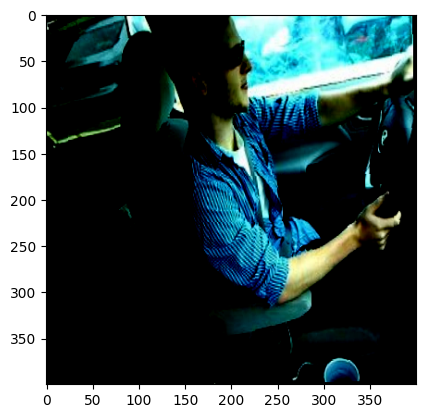

In [10]:
img,c = data[0]
print(img.shape)
print("Label:", classes[c], f"({class_dict[c]})")
# imshow expects (height,width,channels)
# but image tensors have (channels,width,height), impermute is used to map these properly
plt.imshow(img.permute(1,2,0))  
plt.show()

In [11]:
device = torch.device("cuda:0")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
NVIDIA GeForce GTX 1650


In [12]:
import torch
from torch.cuda.amp import GradScaler
scaler = GradScaler()



In [13]:


#\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad(): # disables gradient calculation during evaluation, no parameter updation 
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc


def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    test_accuracies = []
    # set the model to train mode initially
    model.train()
    for epoch in tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for data in train_loader:

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # Clears the gradients of all optimized tensors. 
            
            # forward + backward + optimize
            # output contains probability of each class
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1) # select max prob - label
            loss = criterion(outputs, labels) # compute loss
            loss.backward() # compute gradients of loss
            optimizer.step() # update parameters based on gradients
            
            # calculate the loss/acc later
            running_loss += loss.item() # accumulates loss across batch
            running_correct += (labels==predicted).sum().item() #no of correct predictions

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100/32*running_correct/len(train_loader)

        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval() # dropout layers and batch normalization layers are disabled
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc) # adjust learining rates based on test_acc
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies



model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features # retrieves number of input features

model_ft.fc = nn.Linear(num_ftrs, 10) #add a new layer for no. of output classes = 10
model_ft = model_ft.to(device) # move model to device

criterion = nn.CrossEntropyLoss() # loss function used Cross entropy loss

# optimizer is Stochastic Gradient Descent (SGD) with learning rate = 0.01 and momentum = 0.9 to accelerate convergence
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# define learning rate scheduler that reduce learning rate after 3 epochs if there is no improvement,by maximum 0.9 i.e threshold
lrscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)




c:\Users\Dareen\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dareen\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
torch.cuda.amp.autocast()

In [15]:
torch.cuda.empty_cache()

In [16]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=3)

  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\Dareen\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\Dareen\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 176.00 MiB. GPU  (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\Dareen\AppData\Local\Programs\Python\Python39\lib\site-pa

Epoch 1, duration: 1061 s, loss: 0.4094, acc: 32.6261


 33%|███▎      | 1/3 [19:13<38:26, 1153.21s/it]

Accuracy of the network on the test images: 95 %
Epoch 2, duration: 1258 s, loss: 0.1157, acc: 36.2312


 67%|██████▋   | 2/3 [41:59<21:18, 1278.74s/it]

Accuracy of the network on the test images: 97 %
Epoch 3, duration: 1403 s, loss: 0.0663, acc: 36.7677


100%|██████████| 3/3 [1:07:24<00:00, 1348.19s/it]

Accuracy of the network on the test images: 95 %
Finished Training


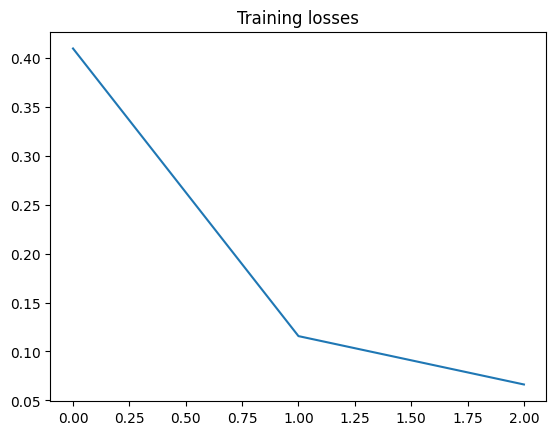

In [17]:
plt.title('Training losses')
plt.plot(training_losses)
plt.show()

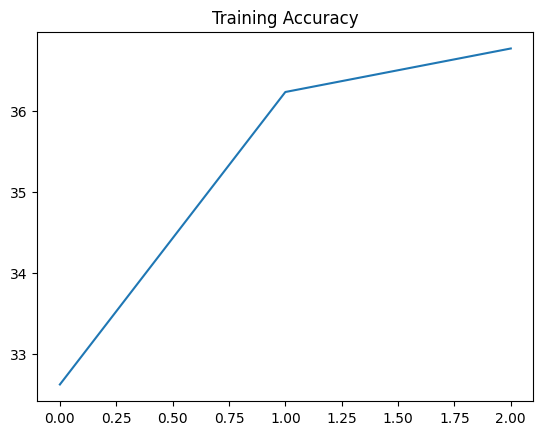

In [18]:
plt.title('Training Accuracy')
plt.plot(training_accs)
plt.show()

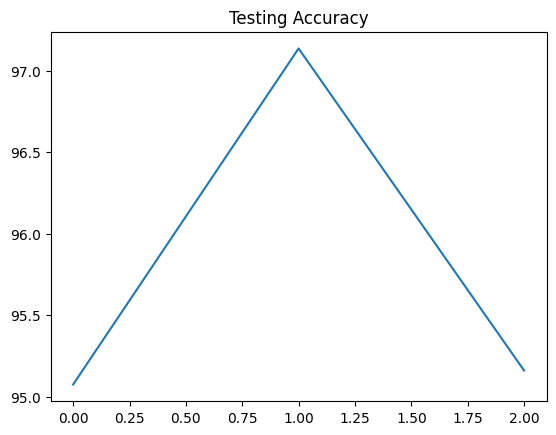

In [19]:
plt.title('Testing Accuracy')
plt.plot(test_accs)
plt.show()

In [21]:
import torch
torch.save(model_ft.state_dict(),"C:/Users/Dareen/OneDrive/Desktop/graduation/distracted3.h5" )

In [22]:
model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load("C:/Users/Dareen/OneDrive/Desktop/graduation/distracted3.h5"))
model.eval()
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
import os
path_test = "C:/Users/Dareen/OneDrive/Desktop/graduation/distractedtest"
list_img_test = [img for img in os.listdir(path_test) if not img.startswith(".")]
list_img_test.sort()

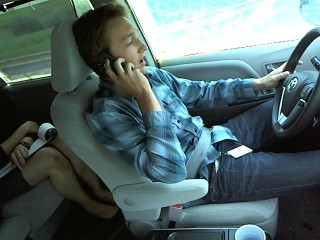

[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Predicted class: talking on the phone - right
Confidence: 1.0


In [24]:
file = random.choice(list_img_test)
im_path = os.path.join(path_test,file)
display(Image(filename=im_path))
with PIL.Image.open(im_path) as im:
    im = transform(im)
    im = im.unsqueeze(0) # Adds a batch dimension to the image tensor
    output = model(im.cuda())
    proba = nn.Softmax(dim=1)(output) # to convert output into probability
    proba = [round(float(elem),4) for elem in proba[0]]
    print(proba)
    print("Predicted class:",class_dict[proba.index(max(proba))])
    print("Confidence:",max(proba))

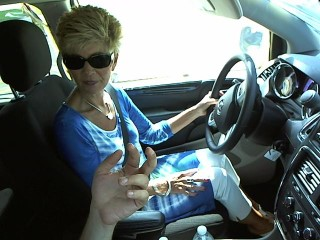

[0.0008, 0.1086, 0.0026, 0.0003, 0.0021, 0.0004, 0.1167, 0.0159, 0.7408, 0.0117]
Predicted class: hair and makeup
Confidence: 0.7408


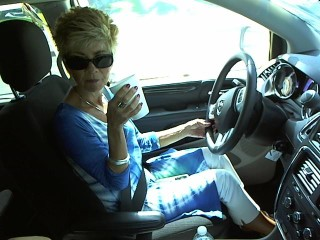

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Predicted class: drinking
Confidence: 1.0


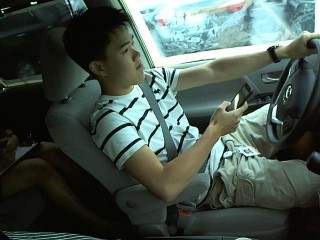

[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Predicted class: texting - right
Confidence: 1.0


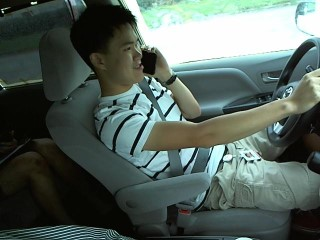

[0.0, 0.0, 0.0, 0.0, 0.7817, 0.0, 0.0, 0.0, 0.2179, 0.0004]
Predicted class: talking on the phone - left
Confidence: 0.7817


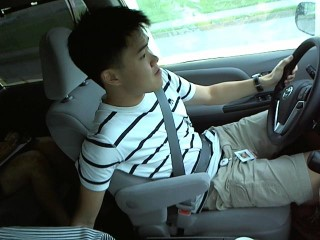

[0.0001, 0.0159, 0.0002, 0.0, 0.0, 0.0, 0.0003, 0.9713, 0.0082, 0.004]
Predicted class: reaching behind
Confidence: 0.9713


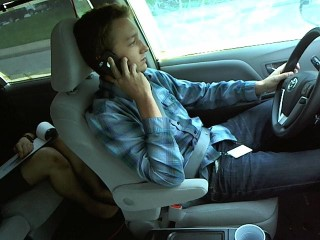

[0.0, 0.0, 0.9998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001]
Predicted class: talking on the phone - right
Confidence: 0.9998


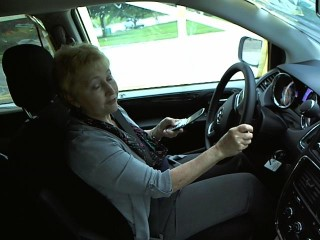

[0.0002, 0.0, 0.0, 0.9995, 0.0002, 0.0, 0.0, 0.0, 0.0, 0.0]
Predicted class: texting - left
Confidence: 0.9995


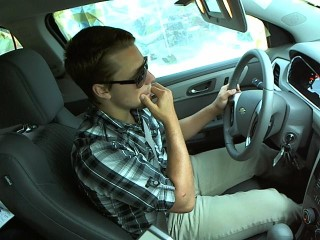

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9999, 0.0001]
Predicted class: hair and makeup
Confidence: 0.9999


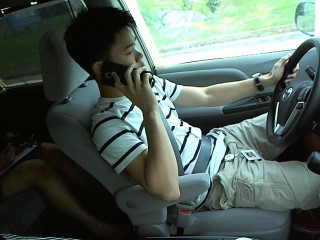

[0.0, 0.0, 0.9701, 0.0, 0.0, 0.0, 0.0001, 0.0, 0.0287, 0.0011]
Predicted class: talking on the phone - right
Confidence: 0.9701


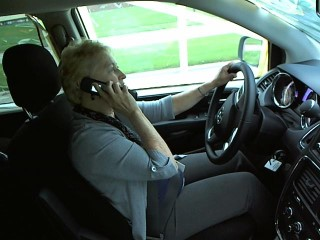

[0.0, 0.0, 0.9999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001, 0.0]
Predicted class: talking on the phone - right
Confidence: 0.9999


In [25]:
list_img_test = os.listdir(path_test)
selected_files = random.sample(list_img_test, 10)
for file in selected_files:
    im_path = os.path.join(path_test, file)
    display(Image(filename=im_path))
    
    with PIL.Image.open(im_path) as im:
        im = transform(im)
        im = im.unsqueeze(0)  # Adds a batch dimension to the image tensor
        im = im.cuda()  # Move tensor to GPU
        output = model(im)
        proba = nn.Softmax(dim=1)(output)  # Convert output into probability
        proba = [round(float(elem), 4) for elem in proba[0]]
        print(proba)
        print("Predicted class:", class_dict[proba.index(max(proba))])
        print("Confidence:", max(proba))